#### Notebook `Feature Selection`

#### Group:
- `Miguel Matos - 20221925`
- `André Nicolau - 20221861`
- `André Ferreira - 20250398`

---

#### <font> Table of Contents </font> <a class="anchor" id='toc'></a> 
1. [Imports](#Imports)
2. [Feature Selection](#feature-selection)


# Imports
[Back to TOC](#toc)

In [1]:
from functions import *

In [2]:
X_train = pd.read_csv("../data/X_train.csv", index_col= "carID")
y_train = pd.read_csv("../data/y_train.csv", index_col= "carID")

X_val = pd.read_csv("../data/X_val.csv", index_col= "carID")
y_val = pd.read_csv("../data/y_val.csv", index_col= "carID")

#For testing categorical variables
X_categoricals = pd.read_csv("../data/data_cleaned.csv", index_col= "carID")

pd.set_option("display.max_columns", None)

# Feature Selection
[Back to TOC](#toc)


Let's start by creating a dictionary that will be used to count the amoung of times a variables is pointed to be deleted or not.

In [3]:
variable_scoreboard = {column: 0 for column in X_train.columns}
variable_scoreboard

{'car_age': 0,
 'mileage': 0,
 'tax': 0,
 'mpg': 0,
 'engineSize': 0,
 'paintQuality%': 0,
 'previousOwners': 0,
 'Audi': 0,
 'BMW': 0,
 'Ford': 0,
 'Hyundai': 0,
 'Mercedes': 0,
 'Opel': 0,
 'Skoda': 0,
 'Toyota': 0,
 'VW': 0,
 'Diesel': 0,
 'Hybrid': 0,
 'Petrol': 0,
 'Automatic': 0,
 'Manual': 0,
 'Semi-Auto': 0}

## Correlation Matrix

Firstly, let's take a look a highly correlated features that can give us an insight for which variables to drop.

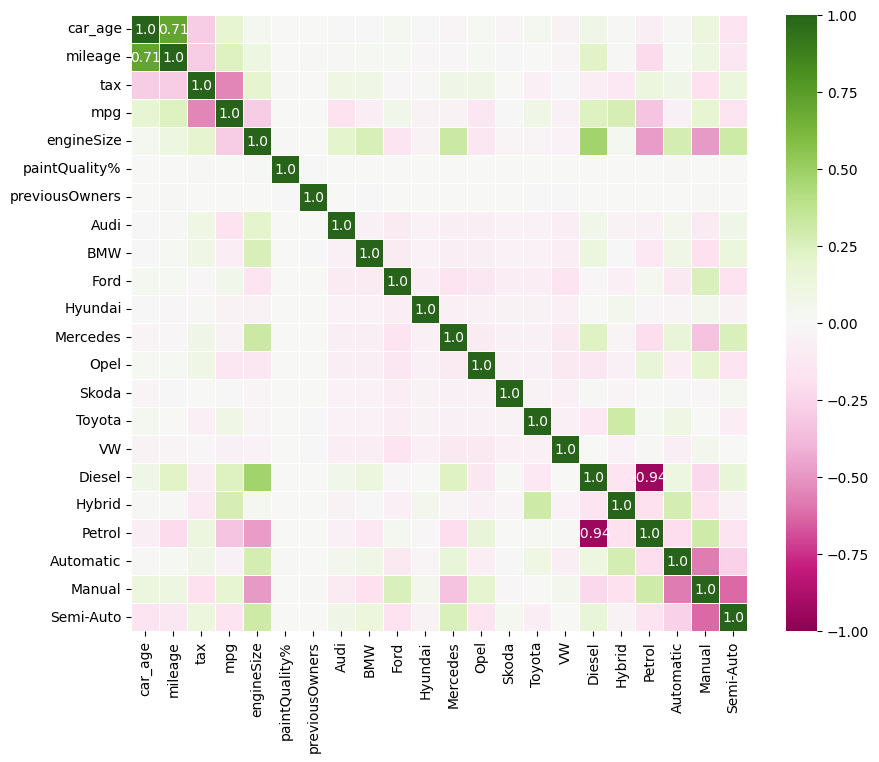

In [4]:
correlation_matrix(X_train, 0.7)

- "car_age" and "mileage" have a high correlation, of 71%, but we still need to look at other feature selection techniques to get more insights and to decide whether either "car_age" or "mileage" are up to remove.

- "Diesel" and "Petrol" have a really high correlation of 94%, which means one of them will very likely be eliminated.

In [5]:
variable_scoreboard["car_age"] += 1
variable_scoreboard["mileage"] += 1
variable_scoreboard["Diesel"] += 1
variable_scoreboard["Petrol"] += 1

## Chi-Square Test on Categorical variables

For this test, we'll use the dataset cleaned, but not yet encoded or scaled.

In [6]:
X_categoricals = X_categoricals.select_dtypes(exclude= np.number)
indexes = X_train.index.to_list() #Getting the indexes of the X_train
X_train_cat = X_categoricals.loc[indexes] # Getting only the rows that correspond to X_train
X_train_cat.head()

,Brand,model,transmission,fuelType
carID,,,,
31106,Ford,Focus,Unknown,Diesel
52908,Toyota,Avensis,Manual,Diesel
21218,Ford,Focus,Manual,Petrol
15728,Ford,Fiesta,Manual,Petrol
68286,VW,Sharan,Semi-Auto,Diesel


In [7]:
# Transforming y_train into a Series
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.iloc[:, 0]

In [8]:
for var in X_train_cat:
    TestIndependence(X_train_cat[var],y_train, var)

Brand is IMPORTANT for Prediction
model is IMPORTANT for Prediction
transmission is IMPORTANT for Prediction
fuelType is IMPORTANT for Prediction


Looks like all the variables are important for the model.

## Wrapper Methods

In [9]:
model = LinearRegression()
len(X_train.columns)

22

In [10]:
#no of features
nof_list=np.arange(1,len(X_train.columns)+1)            
high_score=0

#Variable to store the optimum features
nof=0           
train_score_list =[]
val_score_list = []

for n in range(len(nof_list)):
    model = LinearRegression()
    
    rfe = RFE(estimator = model,n_features_to_select = nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_val_rfe = rfe.transform(X_val)
    model.fit(X_train_rfe,y_train)
    
    #storing results on training data
    train_score = model.score(X_train_rfe,y_train)
    train_score_list.append(train_score)
    
    #storing results on validation data
    val_score = model.score(X_val_rfe,y_val)
    val_score_list.append(val_score)
    
    #check best score
    if(val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]
        
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 22
Score with 22 features: 0.717746


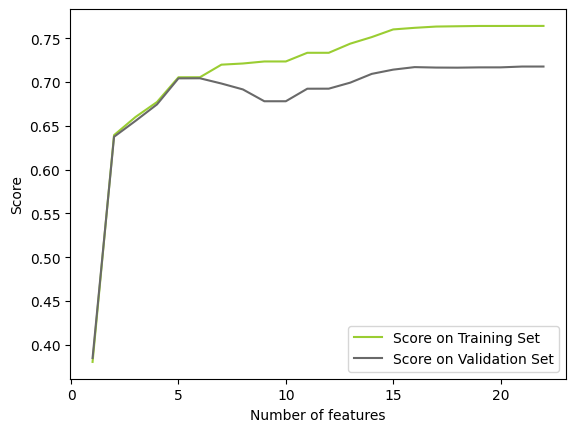

In [11]:
plt.plot(list(range(1,23)), train_score_list, label="Score on Training Set", color='yellowgreen')
plt.plot(list(range(1,23)), val_score_list, label="Score on Validation Set", color='dimgray')
plt.xlabel("Number of features")
plt.ylabel("Score")
plt.legend()
plt.show()

Using a wrapper method with Linear regression, seems that every feature is important as the best score was with all the features.

##  Embedded Methods

### Lasso Regression

In [ ]:
brands = X_categoricals["Brand"].unique().tolist()
brands

['Audi',
 nan,
 'BMW',
 'Ford',
 'Hyundai',
 'Mercedes',
 'Skoda',
 'Toyota',
 'Opel',
 'VW']

In [12]:
reg = LassoCV()
reg.fit(X_train, y_train)
coef = pd.Series(reg.coef_, index = X_train.columns)

In [13]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 18 variables and eliminated the other 4 variables


In [14]:
coef.sort_values()

car_age          -4100.153881
mpg              -2749.163166
mileage          -2434.433204
Manual           -2037.847299
Petrol            -832.862123
tax               -437.922519
Opel              -304.715696
Toyota            -200.963555
Hyundai           -182.390809
Skoda             -137.423948
Ford               -58.173835
previousOwners       0.000000
paintQuality%       -0.000000
Diesel              -0.000000
Automatic            0.000000
VW                  18.354763
BMW                275.251873
Mercedes           309.948070
Audi               415.363722
Semi-Auto          851.976183
Hybrid            3850.405255
engineSize        5668.831107
dtype: float64

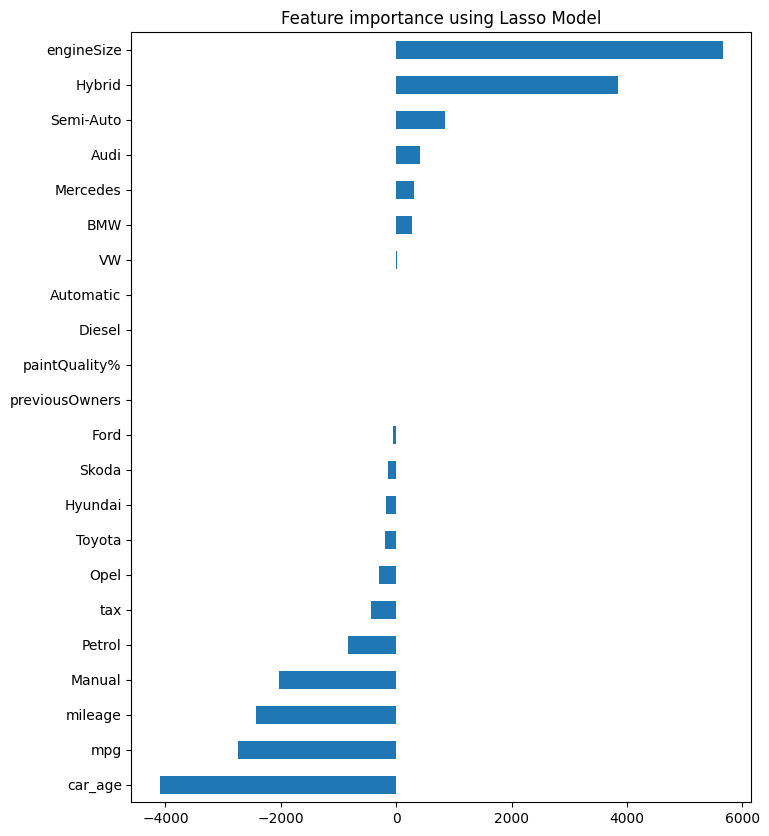

In [15]:
# CODE HERE
plot_importance(coef,'Lasso')

Based on the embbeded method Lasso, "previousOwners", "paintQuality%", "Diesel" and "Automatic" are insignificant, as their coefficient is equal to 0.

In [16]:
variable_scoreboard["previousOwners"] += 1
variable_scoreboard["paintQuality%"] += 1
variable_scoreboard["Diesel"] += 1
variable_scoreboard["Automatic"] += 1

### Ridge Regression

In [17]:
reg = Ridge()
reg.fit(X_train, y_train)
coef = pd.Series(reg.coef_, index = X_train.columns)

In [20]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables.")

Lasso picked 22 variables and eliminated the other 0 variables.


In [21]:
coef.sort_values()

car_age          -4112.576998
mpg              -2860.309619
mileage          -2440.830977
Petrol           -1996.991617
Diesel           -1087.154227
tax               -468.420366
Opel              -307.098346
Toyota            -215.695188
Hyundai           -191.554072
Skoda             -146.474288
Ford               -59.142280
paintQuality%      -27.406490
previousOwners      14.617947
VW                  16.349323
BMW                273.930510
Mercedes           309.466941
Audi               413.512707
Manual             635.710045
Automatic         2592.095837
Hybrid            3387.402863
Semi-Auto         3552.986094
engineSize        5646.573290
dtype: float64

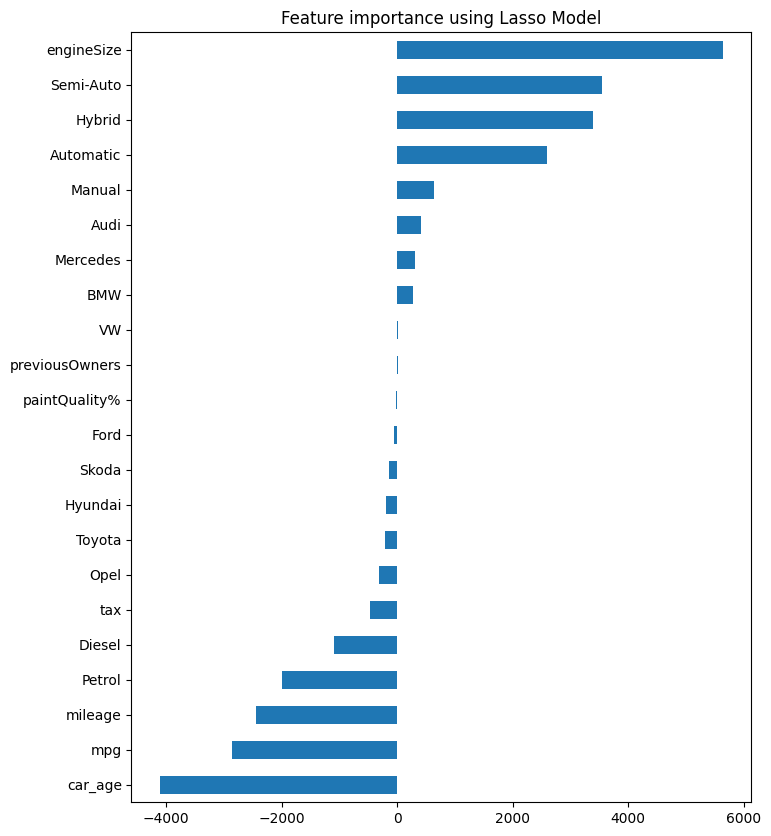

In [22]:
# CODE HERE
plot_importance(coef,'Lasso')

In [18]:
variable_scoreboard = {key: np.round(value/3, 2) for key, value in variable_scoreboard.items() if value > 0}
variable_scoreboard

{'car_age': 0.33,
 'mileage': 0.33,
 'paintQuality%': 0.33,
 'previousOwners': 0.33,
 'Diesel': 0.67,
 'Petrol': 0.33,
 'Automatic': 0.33}